Clustering experiments
======================

I hope that by interrogating various ways of looking at the newspaper text placement and the way it is aligned on a page, that some sort of grouping might surface. From the selection of poetry, it seems that a poem is likely to have an aligned left edge to the text, but a more wildly varying left edge.

'clustering.py' can create a database of vectors for a given date range slice of the (readable) Burney newspaper archive. This vector can then be used to investigate various coorelations to see if, in fact, it is possible to cluster the text columns in such a way that poetry is very likely to be found near each other.

Further to this, one we have a means of creating interesting clusters of text, we can ask it about other data and find out which cluster it would put the new data. If we find a cluster that is by majority poetry, then if it puts new data into this cluster, we can have a level of confidence that the new data is also like these and a poem.

Plan:
-----

Iterate through the following steps:

 * Pull or derive a set of interesting types of numbers from the dataset. Each block of text will have a set of these numbers (a 'vector').
 * Create a suitable number of clusters using two (though hopefully more) of these types to test.
 * Check to see if these clusters are sensible and are not arbitrary in nature subjectively.
 * Given the set of found poems, see into which clusters the poems get assigned.
 * If a high % of the poems get assigned to a single cluster -> Success! Focus on this!
 * Otherwise, try again from the top.

In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
# Get the dataset:
from clustering import create_cluster_dataset, NewspaperArchive
DBFILE = "1749_1750_no_drift.db"
n = NewspaperArchive()
ds = create_cluster_dataset(n, daterange = [1749, 1750], dbfile = DBFILE)


Loading from db cache '1749_1750_no_drift.db'
14213 vectors loaded.


What do these 'vectors' look like? What do the columns refer to?

In [6]:
data, transform, id_list = ds
print(data.toarray())

print(transform.get_feature_names())

[[  1.50118203e+00   3.17500000e+03  -7.02000000e+02 ...,   4.00000000e+01
    2.29527660e+03   0.00000000e+00]
 [  1.27409262e+00   3.05400000e+03  -9.39743590e+02 ...,   1.43589744e+01
    4.23780408e+02   0.00000000e+00]
 [  7.24040646e-04   2.03000000e+02   2.73333333e+01 ...,   1.92333333e+02
    1.09955556e+03   0.00000000e+00]
 ..., 
 [  4.23819898e-01   2.91800000e+03  -7.98096154e+02 ...,   5.68269231e+01
    6.81933062e+02   0.00000000e+00]
 [  7.25044092e-01   4.11100000e+03  -7.83641509e+02 ...,   3.97547170e+01
    3.07989035e+03   0.00000000e+00]
 [  7.24692526e-02   4.97900000e+03  -8.77267857e+02 ...,   1.81569643e+03
    4.81981824e+02   0.00000000e+00]]
['density', 'ltcount', 'redge_x2ave', 'x1_var1', 'x1_var2', 'x1ave_ledge', 'x2_var1', 'x2_var2']


Going from a vector back to the metadata reference:
---------------------------------------------------

By keeping an 'id_list', we can look up the identifier for any vector in the list from the database we've made for this clustering attemp. This lets us look up what the reference for that is, and where we can find it:

In [7]:
from clustering import ClusterDB
db = ClusterDB(DBFILE)
print(dict(db.vecidtoitem(id_list[-1])))
print(data.toarray()[-1])

from burney_data import BurneyDB
bdb = BurneyDB("burney.db")

bdb.get_title_row(titleAbbreviation="B0574REMEMBRA")

{'block_number': '2', 'page': '0004', 'day': '30', 'newspaper': 'B0574REMEMBRA', 'article': '006', 'id': 18940, 'vector_id': 18940, 'year': '1749', 'month': '12'}
[  7.24692526e-02   4.97900000e+03  -8.77267857e+02   1.94072104e+05
   0.00000000e+00   1.81569643e+03   4.81981824e+02   0.00000000e+00]


{'datesOfPublication': '1747-1751',
 'earliest_issue': None,
 'id': 489,
 'last_issue': None,
 'placeOfPublication': 'LONDON',
 'title': 'REMEMBRANCER (1747)',
 'titleAbbreviation': 'B0574REMEMBRA',
 'titleContinuedBy': 'REMEMBRANCER OR NATIONAL ADVOCATE',
 'titleContinues': '',
 'typeOfPublication': 'NEWSPAPER'}

Initial data woes
-----------------

There was a considerable discrepancy between the x1 average indent and the column "box" left edge. Looking at the data, the presence of a few outliers can really affect this value. Omitting the 2 smallest and largest x values might be enough to avoid this biasing the sample too badly.

Also, the initial 'drift correction' (adjustments made to correct warped or curved columns) seemed to add more issues than it solved, so the dataset was remade without it.

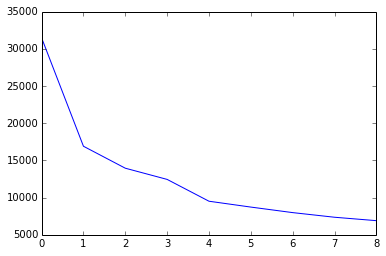

In [4]:
from scipy import cluster
from matplotlib import pyplot as plt
import numpy as np

# Where is the K-means 'elbow'?
# Try between 1 and 10
# use only the x1 and x2 variences
vset = [cluster.vq.kmeans(data.toarray()[:, [3,6]], i) for i in range(1,10)]
plt.plot([v for (c,v) in vset])
plt.show()

Seems the elbow is quite wide and not sharply defined, based on just the line variences. Let's see what it looks like in general.

In [5]:
# Mask off leaving just the front and end variance columns
npdata = data.toarray()
mask = np.ones((8), dtype=bool)
mask[[0,1,2,4,5,7]] = False

marray = npdata[:,mask]

x1 vs x2 varience?
------------------

What is the rough shape of this data? The varience of x1 and x2 are equivalent to the left and right alignment of the text varies in a given block of text.

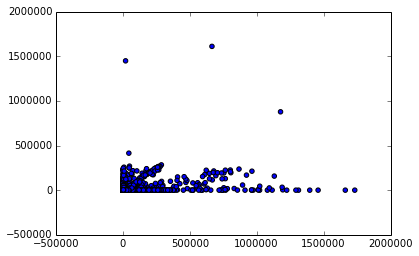

In [6]:
plt.scatter(marray[:,0], marray[:,1])
plt.show()

Attempting K-Means
==================

What sort of clustering algorithm to employ is actually a good question. K-means can give fairly meaningless responses if the data is of a given sort. Generally, it can be useful but cannot be used blindly. 

Given the data above, it might be a good start however.

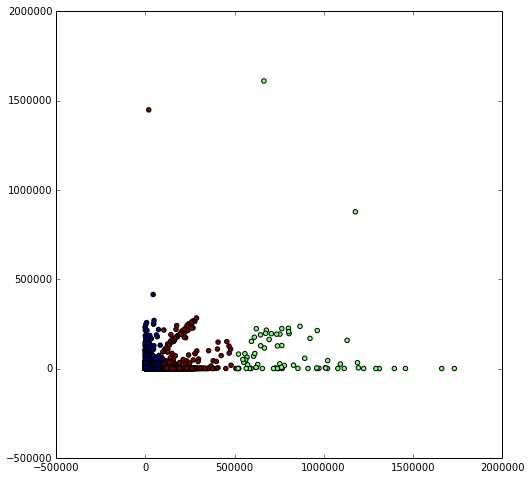

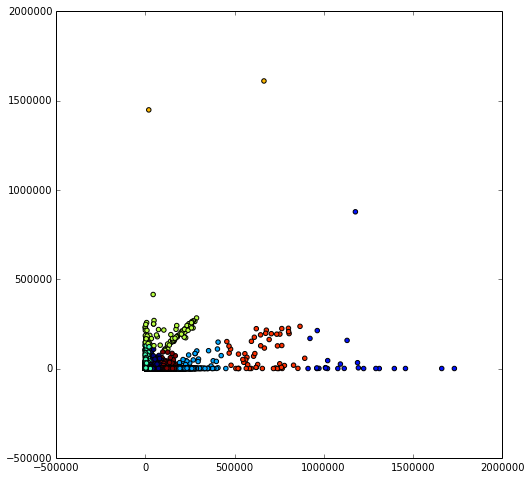

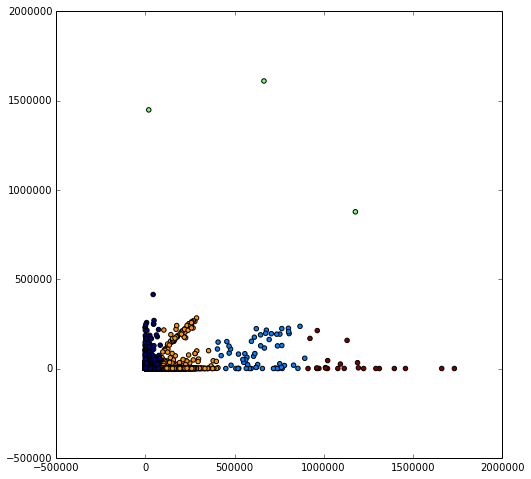

In [7]:
#trying a different KMeans
from sklearn.cluster import KMeans

estimators = {'k_means_3': KMeans(n_clusters=3),
              'k_means_5': KMeans(n_clusters=5),
              'k_means_8': KMeans(n_clusters=8),}

fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(8, 8))
    plt.clf()
    plt.cla()
    est.fit(marray)
    labels = est.labels_
    
    plt.scatter(marray[:,0], marray[:,1], c=labels.astype(np.float))
    fignum = fignum + 1
plt.show()

Interesting!
============

The lack of really well defined clusters bolstered the "elbow" test above. K-means is likely not put to good use here, with just these two variables.

The left edge of the scatterplot is a region that contains those blocks of text with lines aligned to the left edge of the paper's column, but have some considerable variation to the length of the line.

For example, I'd expect text looking like the following:

    Qui quis at ex voluptatibus cupiditate quod quia. 
    Quas fuga quasi sit mollitia quos atque. Saepe atque officia sed dolorem. 
    Numquam quas aperiam eaque nam sunt itaque est. Sed expedita 
    maxime fugiat mollitia error necessitatibus quam soluta. Amet laborum eius
    sequi quae sit sit.

This is promising (as long as the data is realistic and there isn't a bug in generating that...)

Now, I wonder if including the "margin" (x1ave-ledge: average x1 coordinate minus the leftmost edge) might help find or distinguish these further?

In [8]:
mpld3.disable_notebook()  # switch off the interactive graph functionality which doesn't work well with the 3D library

NameError: name 'mpld3' is not defined

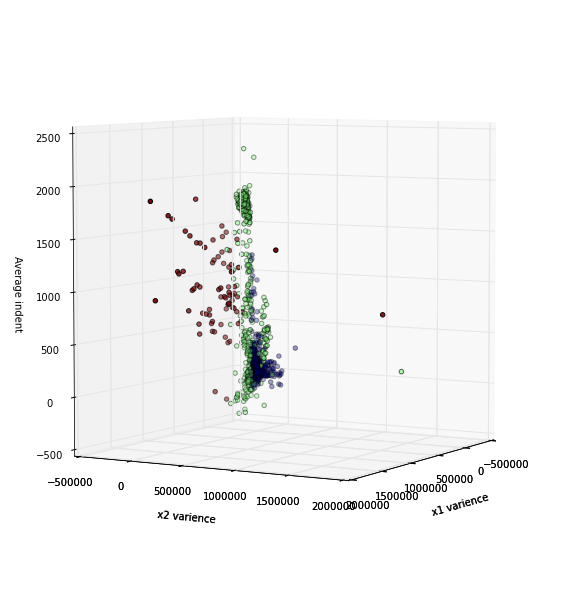

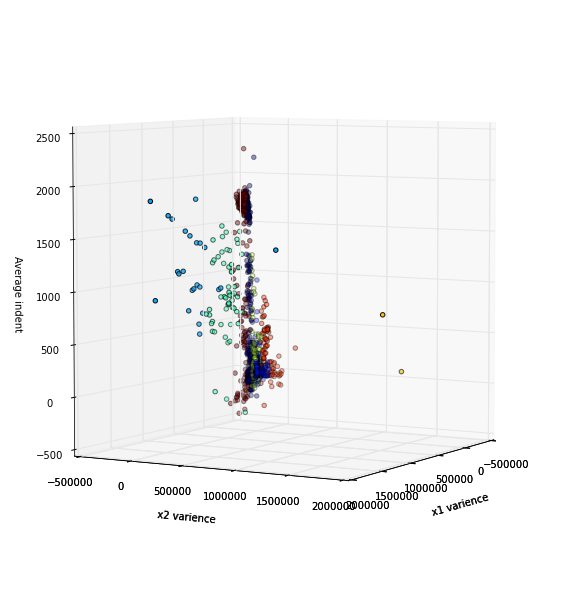

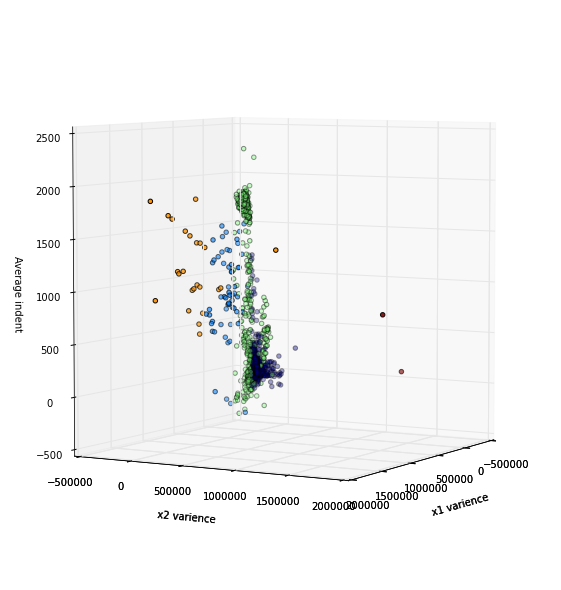

In [9]:
from mpl_toolkits.mplot3d import Axes3D

X = npdata[:, [3,5,6]]

fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(8, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=5, azim=30)
    plt.cla()
    est.fit(X)
    labels = est.labels_
    
    ax.scatter(X[:,0], X[:,2], X[:,1], c=labels.astype(np.float))
    
    ax.set_xlabel('x1 varience')
    ax.set_ylabel('x2 varience')
    ax.set_zlabel('Average indent')
    
    fignum = fignum + 1
plt.show()

How about the area density? In other words, what does it look like if the total area of the block is compared to the area taken up by just the words themselves?

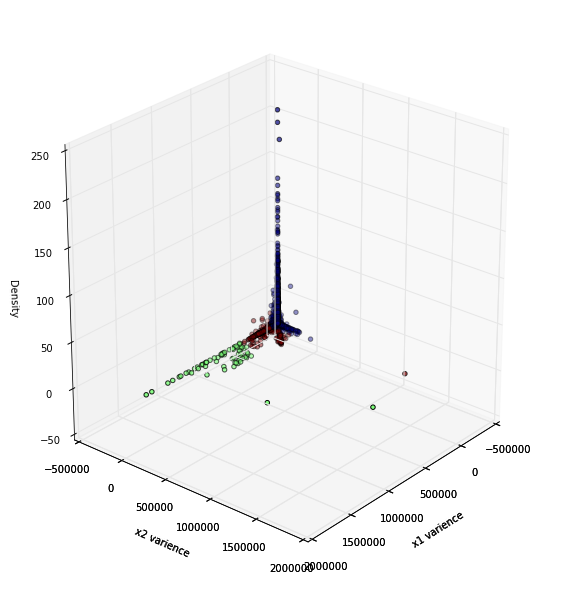

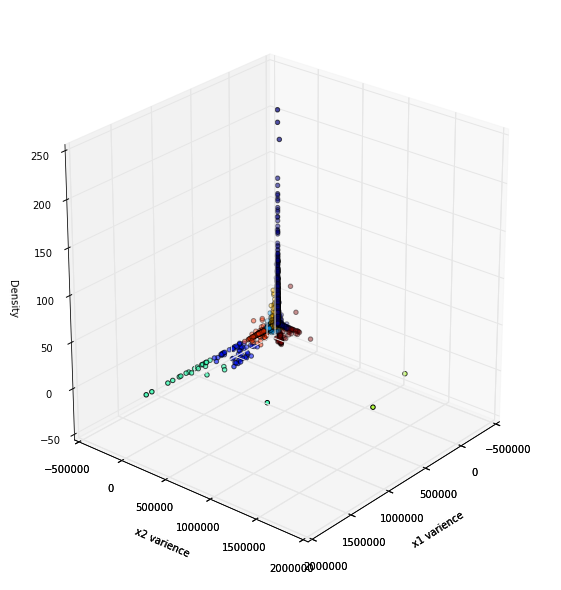

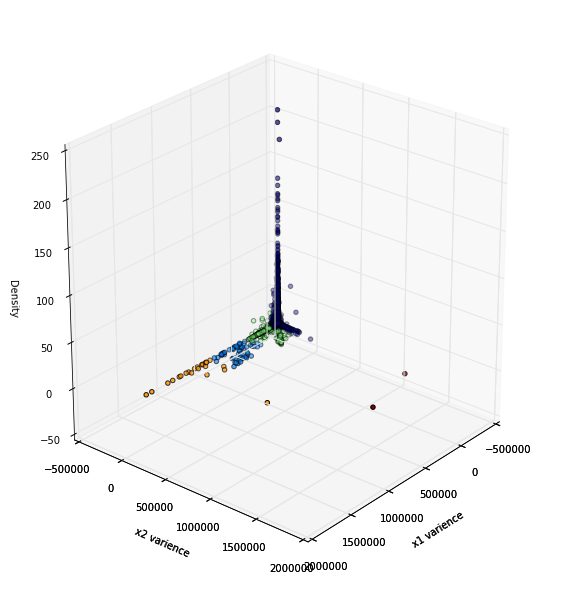

In [10]:
X = npdata[:, [3,0,6]]

fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(8, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=40)
    plt.cla()
    est.fit(X)
    labels = est.labels_
    
    ax.scatter(X[:,0], X[:,2], X[:,1], c=labels.astype(np.float))
    
    ax.set_xlabel('x1 varience')
    ax.set_ylabel('x2 varience')
    ax.set_zlabel('Density')
    
    fignum = fignum + 1
plt.show()

More outliers skewing the results. This time for blocks with nearly zero varience at either end, but a huge amount of letter area attributed to it by the ocr, but sweeping out a very small overall area. Perhaps mask out the columns which aren't actually columns but dividers mistaken for text? ie skip all blocks that are narrow under 100px perhaps. Another way might be to ignore blocks which are under approximately 40 words (40 words * 5 characters)

In [11]:
mask = npdata[:,1] > 40 * 5  # mask based on the ltcount value
print(mask)
print("Amount of vectors: {0}, Vectors with ltcount < 50: {1}".format(len(npdata), sum([1 for item in mask if item == False])))

[ True  True  True ...,  True  True  True]
Amount of vectors: 14212, Vectors with ltcount < 50: 1104


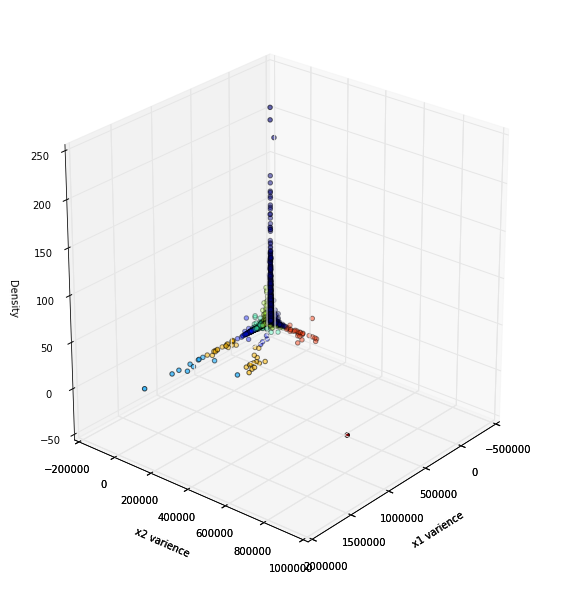

In [12]:
m_npdata = npdata[mask, :]
X = m_npdata[:, [3,0,6]]

# Let's just plot one graph to see:

est = estimators['k_means_8']
fig = plt.figure(fignum, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=40)
plt.cla()
est.fit(X)
labels = est.labels_
    
ax.scatter(X[:,0], X[:,2], X[:,1], c=labels.astype(np.float))
    
ax.set_xlabel('x1 varience')
ax.set_ylabel('x2 varience')
ax.set_zlabel('Density')
    
plt.show()